# Titanic competition

## Introduction

### General description

The sinking of the Titanic is one of the most infamous shipwrecks in history.

On April 15, 1912, during her maiden voyage, the widely considered “unsinkable” RMS Titanic sank after colliding with an iceberg. Unfortunately, there weren’t enough lifeboats for everyone onboard, resulting in the death of 1502 out of 2224 passengers and crew.

While there was some element of luck involved in surviving, it seems some groups of people were more likely to survive than others.

In this challenge, we ask you to build a predictive model that answers the question: “what sorts of people were more likely to survive?” using passenger data (ie name, age, gender, socio-economic class, etc).

### Content
1. Basic data pre-processing
2. EDA, SDA
3. Using classic and gradient boosting models for prediction passengers' survival
4. Methods comparement and general conclusion

### Import dependencies

In [1]:
!pip install phik -q
!pip install catboost -q

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.model_selection import (
    train_test_split,
    RandomizedSearchCV
)
from sklearn.preprocessing import (
    OneHotEncoder,
    OrdinalEncoder,
    StandardScaler,
    MinMaxScaler
)
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import (
    roc_auc_score,
    accuracy_score
)
from catboost import CatBoostClassifier

from phik import phik_matrix

### Data loading

In [3]:
train_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1WMZRFuEMMZOBaoi1qEiuLocs5MnLsHIP')
test_data = pd.read_csv('https://drive.google.com/uc?export=download&id=1mnz1W2YzBPMjIkRq8D9ejzqgGQr9TlJ-')
train_data

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [4]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 11 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  418 non-null    int64  
 1   Pclass       418 non-null    int64  
 2   Name         418 non-null    object 
 3   Sex          418 non-null    object 
 4   Age          332 non-null    float64
 5   SibSp        418 non-null    int64  
 6   Parch        418 non-null    int64  
 7   Ticket       418 non-null    object 
 8   Fare         417 non-null    float64
 9   Cabin        91 non-null     object 
 10  Embarked     418 non-null    object 
dtypes: float64(2), int64(4), object(5)
memory usage: 36.0+ KB


## Pre-processing

### Column names

We will transform columns' names to snake case.

In [6]:
train_data.columns = ['passenger_id', 'survived', 'p_class',
                      'name', 'sex', 'age', 'sib_sp',
                      'parch', 'ticket', 'fare', 'cabin', 'embarked']
test_data.columns = train_data.drop('survived', axis=1).columns

### Missing values

There are missing values in `'age'`, `'cabin'` and `'embarked'` columns. We will take a closer look at them.

#### age

We will check if the missing values are missing at random

In [7]:
age_missing = train_data[train_data['age'].isna()]
age_missing

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
17,18,1,2,"Williams, Mr. Charles Eugene",male,NaN,0,0,244373,13.0000,NaN,S
19,20,1,3,"Masselmani, Mrs. Fatima",female,NaN,0,0,2649,7.2250,NaN,C
26,27,0,3,"Emir, Mr. Farred Chehab",male,NaN,0,0,2631,7.2250,NaN,C
28,29,1,3,"O'Dwyer, Miss. Ellen ""Nellie""",female,NaN,0,0,330959,7.8792,NaN,Q
...,...,...,...,...,...,...,...,...,...,...,...,...
859,860,0,3,"Razi, Mr. Raihed",male,NaN,0,0,2629,7.2292,NaN,C
863,864,0,3,"Sage, Miss. Dorothy Edith ""Dolly""",female,NaN,8,2,CA. 2343,69.5500,NaN,S
868,869,0,3,"van Melkebeke, Mr. Philemon",male,NaN,0,0,345777,9.5000,NaN,S
878,879,0,3,"Laleff, Mr. Kristo",male,NaN,0,0,349217,7.8958,NaN,S


In [8]:
age_missing.groupby('sex')['passenger_id'].count()/len(age_missing)

sex
female    0.299435
male      0.700565
Name: passenger_id, dtype: float64

Women could not tell the age more often than men, but there are more men without specified age (30% vs 70%).

In [9]:
age_missing.groupby('p_class')['passenger_id'].count()/len(age_missing)

p_class
1    0.169492
2    0.062147
3    0.768362
Name: passenger_id, dtype: float64

It seems these missing values can be connected with the class of passenger. Most of people without specifies age were passengers of `'class 3'` (76%).
So we will fill missing values in age with `-1` which means age is `'not stated'`. The third class is the cheapest and that is why data could be lost.

In [10]:
for df in [train_data, test_data]:
    df['age'] = df['age'].fillna(-1)

#### cabin

Most data does not contain information about cabin. We suggest this is connected with class

In [11]:
cabin_missing = train_data[train_data['cabin'].isna()]
cabin_missing

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,-1.0,0,0,330877,8.4583,NaN,Q
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
884,885,0,3,"Sutehall, Mr. Henry Jr",male,25.0,0,0,SOTON/OQ 392076,7.0500,NaN,S
885,886,0,3,"Rice, Mrs. William (Margaret Norton)",female,39.0,0,5,382652,29.1250,NaN,Q
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,-1.0,1,2,W./C. 6607,23.4500,NaN,S


In [12]:
cabin_missing.groupby('p_class')['passenger_id'].count()/len(cabin_missing)

p_class
1    0.058224
2    0.244541
3    0.697234
Name: passenger_id, dtype: float64

It seems these missing values can be connected with the class of passenger. Most of people without specifies age were passengers of `'class 3'` (~70%).
So we will fill missing values in age with `'not stated'`. The third class is the cheapest and that is why data could be lost.

In [13]:
for df in [train_data, test_data]:
    df['cabin'] = df['cabin'].fillna('not_stated')

#### embarked

In [14]:
train_data[train_data['embarked'].isna()]

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
61,62,1,1,"Icard, Miss. Amelie",female,38.0,0,0,113572,80.0,B28,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62.0,0,0,113572,80.0,B28,NaN


It seems these missing values are missing at random. We will fill it with the port where most of people with 1st class embarked.

In [15]:
train_data[train_data['p_class'] == 1].groupby('embarked')['p_class'].count()

embarked
C     85
Q      2
S    127
Name: p_class, dtype: int64

In [16]:
train_data['embarked'] = train_data['embarked'].fillna('S')

#### fare

In [17]:
test_data[test_data['fare'].isna()]

/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1458: RuntimeWarning: invalid value encountered in greater
  has_large_values = (abs_vals > 1e6).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in less
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()
/usr/local/lib/python3.10/dist-packages/pandas/io/formats/format.py:1459: RuntimeWarning: invalid value encountered in greater
  has_small_values = ((abs_vals < 10 ** (-self.digits)) & (abs_vals > 0)).any()


,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
152,1044,3,"Storey, Mr. Thomas",male,60.5,0,0,3701,NaN,not_stated,S


The `'fare'` depends on p_class, so we can fill this missing value with the mode of 'fare' of train_data.

In [18]:
train_data[train_data['p_class'] == 3]['fare'].mode()

0    8.05
Name: fare, dtype: float64

In [19]:
test_data['fare'] = test_data['fare'].fillna(8.05)

Check if we cleared all the missing values.

In [20]:
for df in [train_data, test_data]:
    display(df.isna().sum().sum())

0

0

**Conclusion:** Missing values are filled.

### Duplicated

We will check if there are duplicated data in datasets.

In [21]:
for df in [train_data, test_data]:
    print(df.duplicated().sum())

0
0


There are no duplucates in datasets.

### Pre-processing conclusion
- Missing values are cleared
- There are no duplicates in datasets

## EDA

We will examine the distribution of features detect anomalies and outliers.

### Input features

We will analyse features' distributions using functions.

In [22]:
# Function will be used to display feature distribution as a bar chart
# feature_name_string: name of the feature displayed at the axis
# group_1, group_2: DataFrame, groups compared at chart
def display_bar(feature, feature_name_string, group_1=train_data, group_2=test_data):
    ax = plt.gca()
    data_1 = (group_1
             .pivot_table(index=feature, values='passenger_id', aggfunc='count')
             .reset_index().sort_values(by='passenger_id'))
    data_2 = (group_2
            .pivot_table(index=feature, values='passenger_id', aggfunc='count')
            .reset_index().sort_values(by='passenger_id'))
    data_1.plot(kind='barh', y='passenger_id', x=feature,
               legend=False, color='b', alpha=0.5, ax=ax)
    data_2.plot(kind='barh', y='passenger_id', x=feature,
              legend=False, color='g', alpha=0.5, ax=ax)
    plt.title(f'{feature_name_string} distribution')
    plt.ylabel('Frequency')
    plt.show()

In [23]:
# Function will be used to display feature distribution as a histogram
# feature_name_string: name of the feature displayed at the axis
# group_1, group_2: DataFrame, groups compared at chart
def display_hist(feature, feature_name_string, group_1=train_data, group_2=test_data, bins=30):
    ax = plt.gca()
    group_1[feature].plot(kind='hist', y=feature, bins=bins, color='b', alpha=0.5, ax=ax)
    group_2[feature].plot(kind='hist', y=feature, bins=bins, color='g', alpha=0.5, ax=ax)
    plt.title(f'{feature_name_string} distribution')
    plt.ylabel('Frequency')
    plt.show()
    print(df[feature].describe())

In [24]:
# Function will be used to display feature distribution as a pie chart
# feature_name_string: name of the feature displayed at the axis
def display_pie_chart(feature, feature_name_string, data=train_data):
    (data.pivot_table(index=feature, values='passenger_id', aggfunc='count').plot(
        y='passenger_id', kind='pie', legend=False, autopct='%1.0f%%')
    )
    plt.title(feature_name_string)
    plt.ylabel('')
    plt.show()

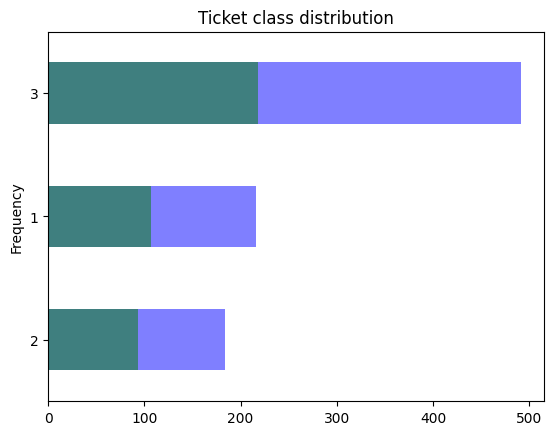

In [25]:
display_bar('p_class', 'Ticket class')

#### Ticket class
- The most frequent class is 3: there are around 50% of all tickets
- 1 and 2 classes are approximately equal in frequency and there are about 25% for each class
- Disctributions are equal in train and test datasets

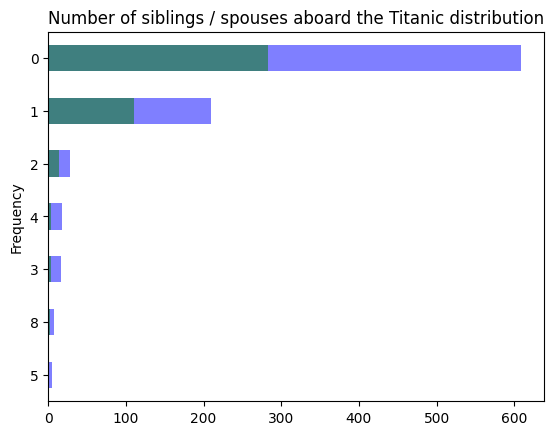

In [26]:
display_bar('sib_sp', 'Number of siblings / spouses aboard the Titanic')

#### Number of siblings / spouses aboard the Titanic
- Most of passengers had 0 siblings and spouses aboard (about 66%). The next category is people who had 1 sibling or a spouse aboard (about 25%). The rest people (<10%) had 2 or more.
- Disctributions are equal in train and test datasets

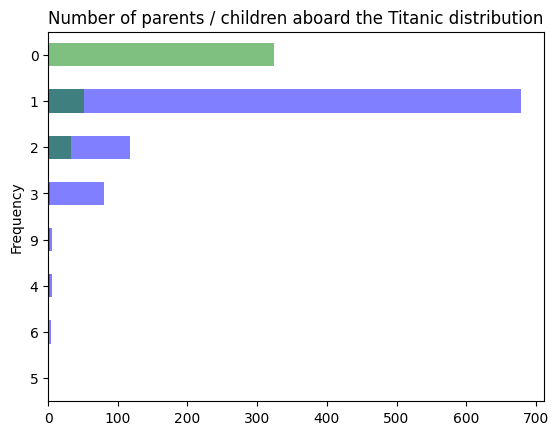

In [27]:
display_bar('parch', 'Number of parents / children aboard the Titanic')

#### Number of parents / children aboard the Titanic
- Most of passengers had 1-2 siblings and spouses aboard (about 90%). The rest people (about 10%) had 2 or more
- The test dataset includes passengers with 0 parents/children aboard **unlike the train dataset, where there are no such people**

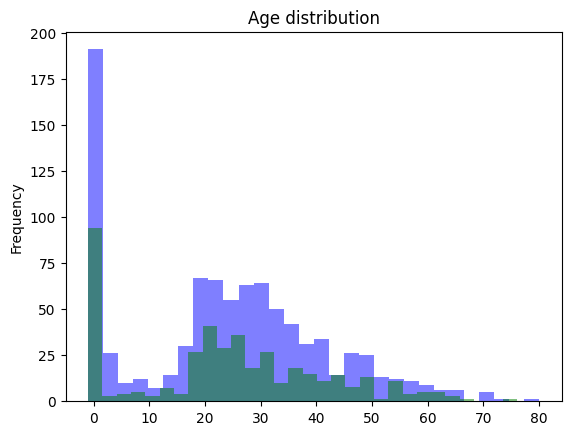

count    418.000000
mean      23.838517
std       17.883723
min       -1.000000
25%        9.000000
50%       24.000000
75%       35.750000
max       76.000000
Name: age, dtype: float64


In [28]:
display_hist('age', 'Age')

#### Age
- Distribution is not normal, median 24, mean about 24. There is a peak at -1 and this value is set instead of `'not stated'`, so this is not an outlier.

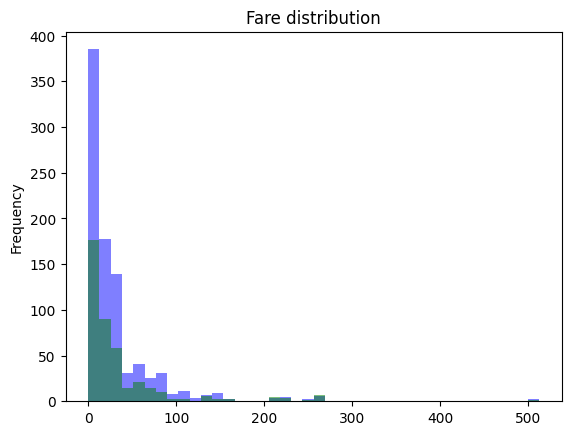

count    418.000000
mean      35.561214
std       55.856789
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: fare, dtype: float64


In [29]:
display_hist('fare', 'Fare', bins=40)

Fare distribution does not seem like a normal distribution and there is a peak at about 0.

In [30]:
train_data[train_data['fare'] < 1]

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
179,180,0,3,"Leonard, Mr. Lionel",male,36.0,0,0,LINE,0.0,not_stated,S
263,264,0,1,"Harrison, Mr. William",male,40.0,0,0,112059,0.0,B94,S
271,272,1,3,"Tornquist, Mr. William Henry",male,25.0,0,0,LINE,0.0,not_stated,S
277,278,0,2,"Parkes, Mr. Francis ""Frank""",male,-1.0,0,0,239853,0.0,not_stated,S
302,303,0,3,"Johnson, Mr. William Cahoone Jr",male,19.0,0,0,LINE,0.0,not_stated,S
413,414,0,2,"Cunningham, Mr. Alfred Fleming",male,-1.0,0,0,239853,0.0,not_stated,S
466,467,0,2,"Campbell, Mr. William",male,-1.0,0,0,239853,0.0,not_stated,S
481,482,0,2,"Frost, Mr. Anthony Wood ""Archie""",male,-1.0,0,0,239854,0.0,not_stated,S
597,598,0,3,"Johnson, Mr. Alfred",male,49.0,0,0,LINE,0.0,not_stated,S
633,634,0,1,"Parr, Mr. William Henry Marsh",male,-1.0,0,0,112052,0.0,not_stated,S


There are only men mostly without specified age and cabin. They seem to be free riders.

Next we will examine people who paid more than 300 pounds.

In [31]:
train_data[train_data['fare'] > 300]

,passenger_id,survived,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
258,259,1,1,"Ward, Miss. Anna",female,35.0,0,0,PC 17755,512.3292,not_stated,C
679,680,1,1,"Cardeza, Mr. Thomas Drake Martinez",male,36.0,0,1,PC 17755,512.3292,B51 B53 B55,C
737,738,1,1,"Lesurer, Mr. Gustave J",male,35.0,0,0,PC 17755,512.3292,B101,C


These passengers bought the most expensive tickets and travelled with the 1st class.

#### Fare
- The distribution is not normal
- Most of people paid 7-30 pounds (75%)
- There are outliers: some people paid 0 (free riders) and 512 pounds (most expensive tickets)

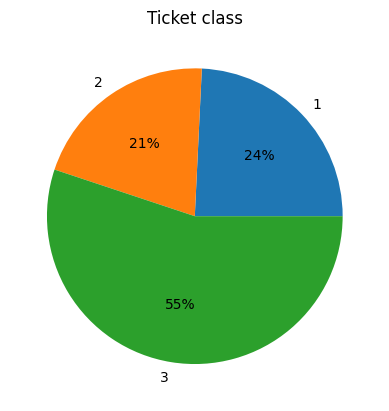

In [32]:
display_pie_chart('p_class', 'Ticket class')

#### Ticket class
- Most of people belong to 3rd class (55%)
- 1st and 2nd class tickets are approximately equal (24% vs 21%)

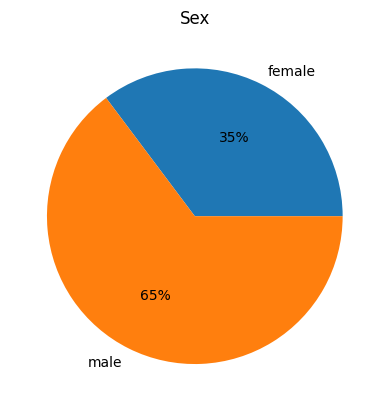

In [33]:
display_pie_chart('sex', 'Sex')

#### Sex
- 35% passengers are women and 65% are men

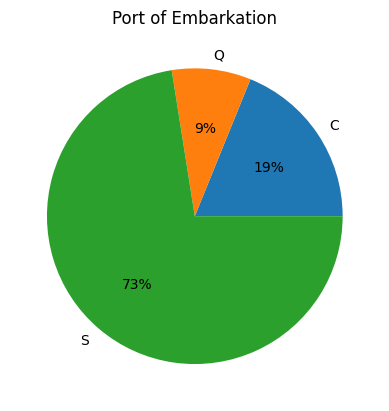

In [34]:
display_pie_chart('embarked', 'Port of Embarkation')

#### Port of embarkement
- Most of people embarked at Southampton (73%), 19% at Cherbourg and 9% at Queenstown

### Target feature

1. We will analyze the target feature distribution and
2. Then we will compare the input features' distributions of passangers who **survived** and of passengers who **did not survive**

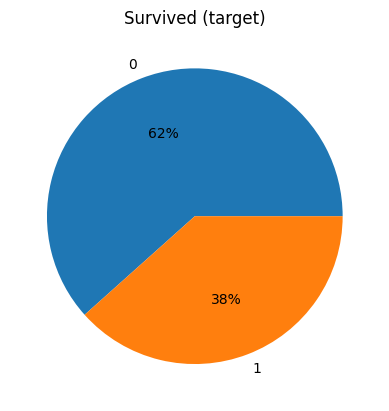

In [35]:
display_pie_chart('survived', 'Survived (target)')

#### Survival distribution
- There is a weak class imbalance: 62% did not survive and 38% survived

#### Comparement

In [36]:
# Data to compare
survived_data = train_data[train_data['survived'] == 1].drop('survived', axis=1)
not_survived_data = train_data[train_data['survived'] == 0].drop('survived', axis=1)

In [37]:
survived_data

,passenger_id,p_class,name,sex,age,sib_sp,parch,ticket,fare,cabin,embarked
1,2,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,not_stated,S
3,4,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
8,9,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,not_stated,S
9,10,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,not_stated,C
...,...,...,...,...,...,...,...,...,...,...,...
875,876,3,"Najib, Miss. Adele Kiamie ""Jane""",female,15.0,0,0,2667,7.2250,not_stated,C
879,880,1,"Potter, Mrs. Thomas Jr (Lily Alexenia Wilson)",female,56.0,0,1,11767,83.1583,C50,C
880,881,2,"Shelley, Mrs. William (Imanita Parrish Hall)",female,25.0,0,1,230433,26.0000,not_stated,S
887,888,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S


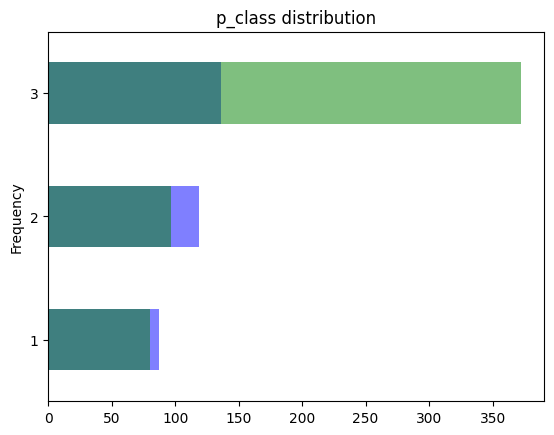

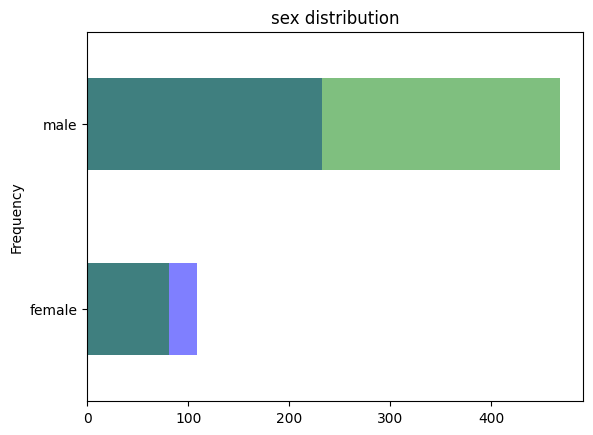

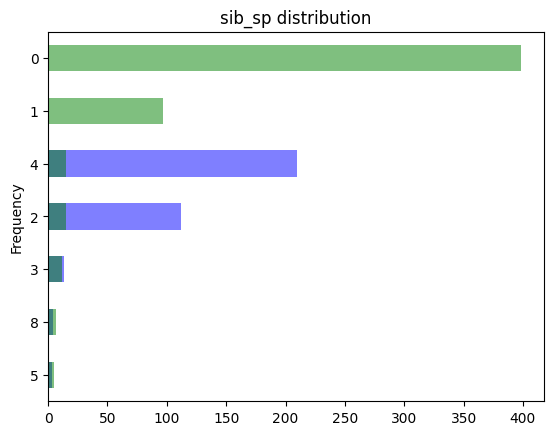

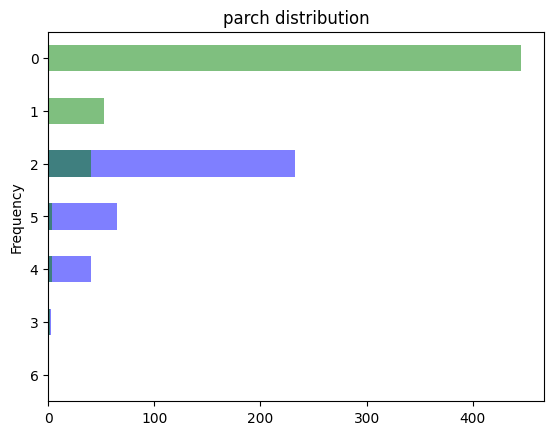

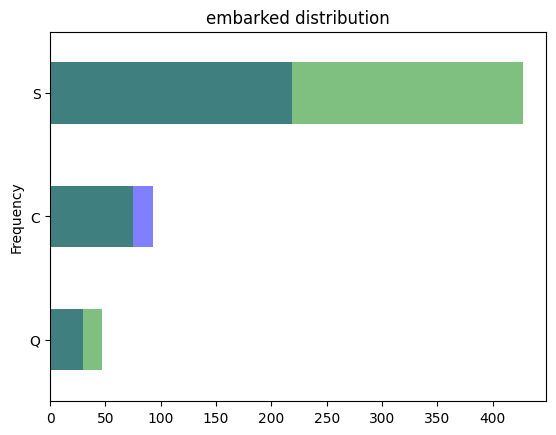

In [38]:
for feature in ['p_class', 'sex', 'sib_sp', 'parch', 'embarked']:
    display_bar(feature, feature, group_1=survived_data, group_2=not_survived_data)

##### Insights
- Most of people from 3rd class (about 60% of survival) did not survive, but people from 1st and 2nd classes mostly survived (about 55% of survival)
- Women were more likely to survive (60% survived), unlike men (40% survived)
- People with 0-1 siblings did not survive at all, while about 90% of people who had aboard 2 or more siblings survived, just like with parents/children (0-1 parch 0% survived, 2 or more - 90% survived)
- 70% of passengers of Southampton and Queenstown did not survive, while 60% of people who embarked at Cherbourg survived.

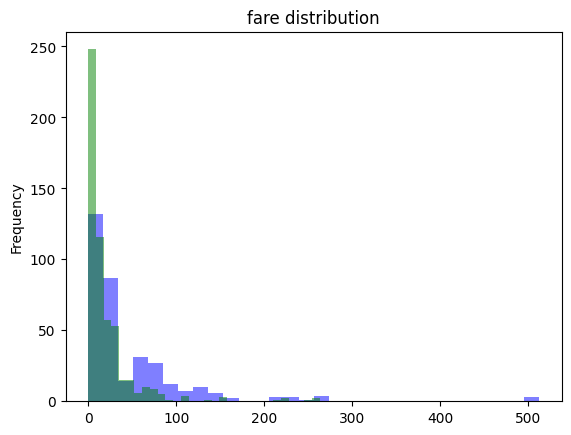

count    418.000000
mean      35.561214
std       55.856789
min        0.000000
25%        7.895800
50%       14.454200
75%       31.471875
max      512.329200
Name: fare, dtype: float64


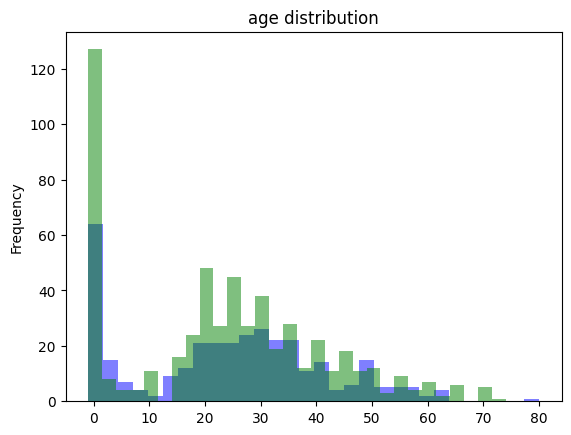

count    418.000000
mean      23.838517
std       17.883723
min       -1.000000
25%        9.000000
50%       24.000000
75%       35.750000
max       76.000000
Name: age, dtype: float64


In [39]:
for feature in ['fare', 'age']:
    display_hist(feature, feature, group_1=survived_data, group_2=not_survived_data)

##### Insights
- Passangers with fare > 10 are more likely to survive
- Age distributions seem to be simmilar

### Correlation analysis

We will use *phik* correlation matrix to examine if there are dependencies between input features and the target

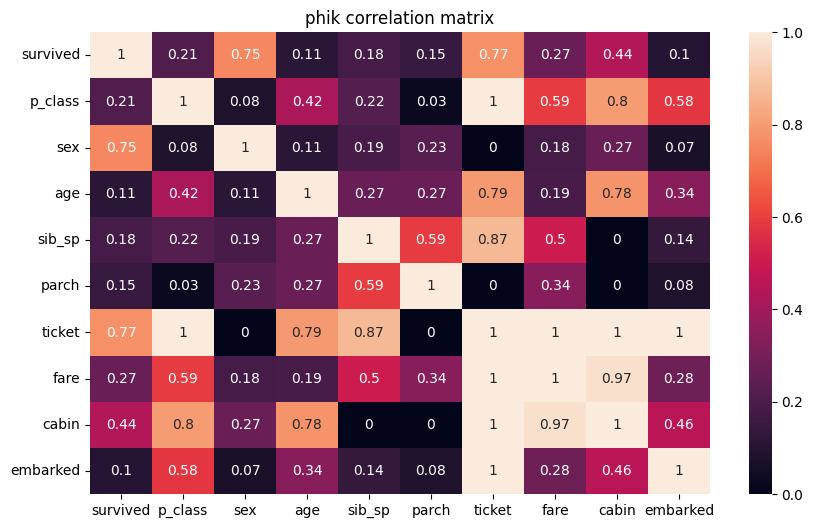

In [40]:
matrix = train_data.drop(['passenger_id', 'name'], axis=1).phik_matrix(
    interval_cols=['age', 'fare']).round(2)
plt.figure(figsize=(10,6))
sns.heatmap(data=matrix, annot=True)
plt.title('phik correlation matrix')
plt.show()

##### Insights according to Chaddock scale
- Strong correlation to target: sex, ticket number
- Weak correlation: cabin
- Negligible correlation: p_class, age, sib_sp, parch, fare, embarked
- 'ticket' feature is multicollinear with p_class, and sib_sp. As the ticket's number is just a row of numbers and letters and there could not be business logic in it, so we will remove it.

In [41]:
train_data = train_data.drop('ticket', axis=1)

### Feature engeneering

#### Additional boxplots analysis
We will examine boxplots: numeric feature distributions by Survival. As fare contains outliers (extremely high prices), we will use np.log function to lower outliers' influence.

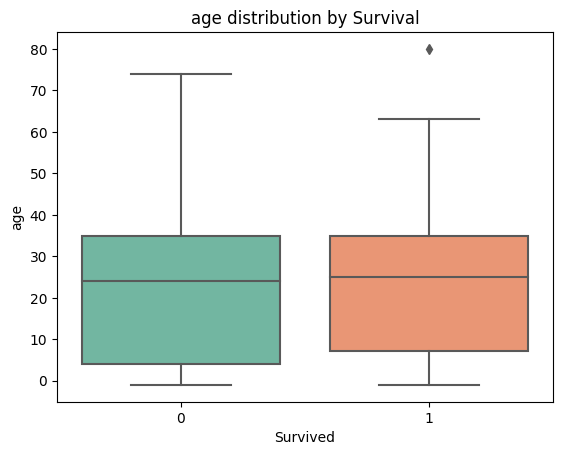

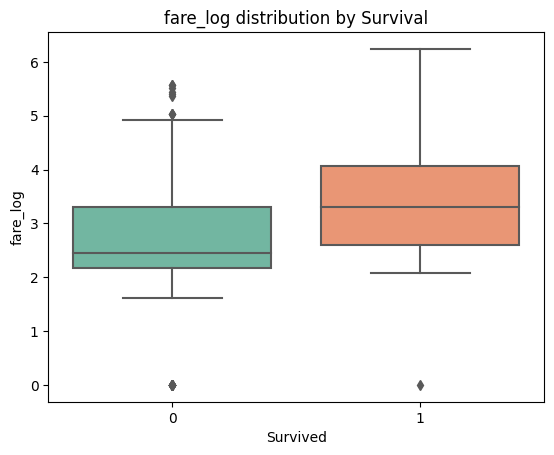

In [42]:
train_data['fare_log'] = train_data['fare'].apply(np.log1p)
for numeric_feature in ['age','fare_log']:
    sns.boxplot(data=train_data, x='survived', y=numeric_feature, palette='Set2')
    plt.xlabel('Survived')
    plt.title(f'{numeric_feature} distribution by Survival')
    plt.show()

##### Insights
- Age distributions are approximately equal, people from 60-70 had less chances to survive (3rd quantile comparement)
- Fare distributions are very different

#### Family members

As we discovered a correlation between number of parents/children, siblings/spouses and target, we will try to make these features more representative by creating binary categorical features: we will find the number of family members and create a binary feature - family membrers aboard (1 - yes, 0 - no)

In [43]:
def make_binary(feature):
    if feature > 0:
        return 1
    else:
        return 0

# Finding general number of family members aboard
train_data['family'] = train_data['sib_sp'] + train_data['parch']
train_data['alone'] = train_data['family'].apply(make_binary)

#### Feature selection

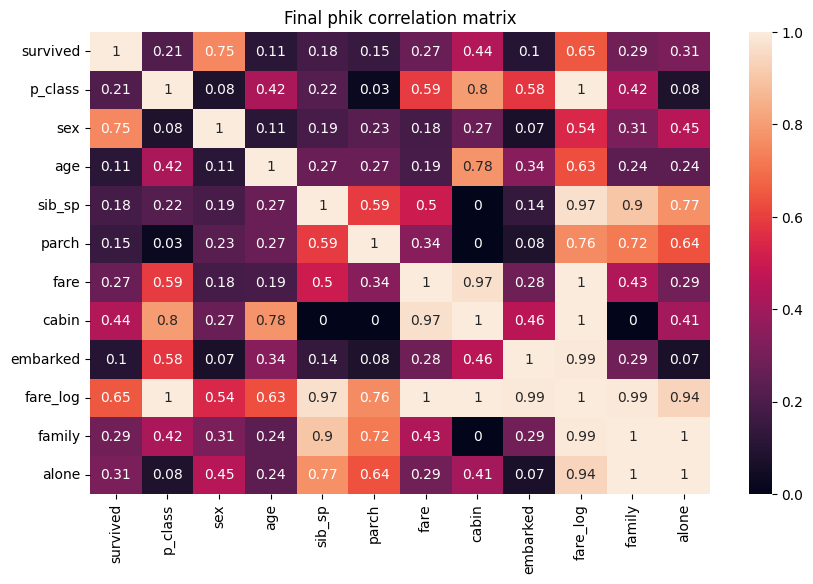

In [44]:
matrix = train_data.drop(['passenger_id', 'name'], axis=1).phik_matrix(
    interval_cols=['age', 'fare']).round(2)
plt.figure(figsize=(10,6))
sns.heatmap(data=matrix, annot=True)
plt.title('Final phik correlation matrix')
plt.show()

##### Insights
- fare_log feature demonstrates moderate correlation, while fare demonstrates negligible
- alone binary feature demonstrates a weak correlation, while sib_sp and parch demonstrate negligible

We will remove unnecessary features, because now we have better features.

In [45]:
train_data = train_data.drop(
    ['fare', 'family', 'sib_sp', 'parch', 'name'], axis=1)

# Test dataset changing
test_data['fare_log'] = test_data['fare'].apply(np.log1p)
test_data['family'] = test_data['sib_sp'] + test_data['parch']
test_data['alone'] = test_data['family'].apply(make_binary)
test_data = test_data.drop(
    ['fare', 'family', 'sib_sp', 'parch', 'name'], axis=1)

### Conclusions
#### EDA
- Ticket class: The most frequent class is 3: there are around 50% of all tickets. 1 and 2 classes are approximately equal in frequency and there are about 25% for each class. Disctributions are equal in train and test datasets
- Number of siblings / spouses aboard the Titanic: Most of passengers had 0 siblings and spouses aboard (about 66%). The next category is people who had 1 sibling or a spouse aboard (about 25%). The rest people (<10%) had 2 or more. Disctributions are equal in train and test datasets
- Number of parents / children aboard the Titanic: Most of passengers had 1-2 siblings and spouses aboard (about 90%). The rest people (about 10%) had 2 or more. The test dataset includes passengers with 0 parents/children aboard unlike the train dataset, where there are no such people
- Age: Distribution is not normal, median 24, mean about 24. There is a peak at -1 and this value is set instead of 'not stated', so this is not an outlier.
- Fare: The distribution is not normal. Most of people paid 7-30 pounds (75%). There are outliers: some people paid 0 (free riders) and 512 pounds (most expensive tickets)
- Ticket class: Most of people belong to 3rd class (55%). 1st and 2nd class tickets are approximately equal (24% vs 21%)
- Sex: 35% passengers are women and 65% are men
- Port of embarkement: Most of people embarked at Southampton (73%), 19% at Cherbourg and 9% at Queenstown
- **Survival (target)** distribution: There is a weak class imbalance: 62% did not survive and 38% survived
- Survived vs Not Survived comparement:
    - Most of people from 3rd class (about 60% of survival) did not survive, but people from 1st and 2nd classes mostly survived (about 55% of survival)
    - Women were more likely to survive (60% survived), unlike men (40% survived)
    - People with 0-1 siblings did not survive at all, while about 90% of people who had aboard 2 or more siblings survived, just like with parents/children (0-1 parch 0% survived, 2 or more - 90% survived)
    - 70% of passengers of Southampton and Queenstown did not survive, while 60% of people who embarked at Cherbourg survived.
#### Feature engeneering
Created features (`'alone'`, `'fare_log'`) that correlate to the target more than the old ones:
- fare_log feature demonstrates moderate correlation, while fare demonstrates negligible
- alone binary feature demonstrates a weak correlation, while sib_sp and parch demonstrate negligible
- removed 'fare', 'sib_sp', 'parch'

## Models training

In [46]:
np.random.seed(42)

# Lists with features names
ord_list = ['sex', 'age', 'alone', 'p_class', 'cabin', 'embarked']
num_list = ['fare_log']

# Train sample and target
X_train = train_data.drop(['passenger_id', 'survived'], axis=1)
y_train = train_data['survived']

# Hyperparameters selection
params = [
    {'models': [DecisionTreeClassifier()],
     'models__min_samples_split': range(2, 5),
     'models__max_depth': range(2, 6),
     'models__min_samples_leaf': range(2, 7)},
    {'models': [SVC(probability=True)],
     'models__C': [0.1, 1, 3, 5]},
    {'models': [KNeighborsClassifier()],
     'models__n_neighbors': (5, 20)},
    {'models': [CatBoostClassifier(verbose=False)],
     'models__max_depth': range(3, 6),
     'models__l2_leaf_reg': [5, 10]
    }
]

# Pipelines
ord_pipe = Pipeline(
    [
        ('ord', OrdinalEncoder(categories='auto',
                handle_unknown='use_encoded_value', unknown_value=-1))
    ]
)

data_preprocessor = ColumnTransformer(
    [
        ('ord', ord_pipe, ord_list),
        ('num', StandardScaler(), num_list)
    ],
    remainder='passthrough'
)

final_pipe = Pipeline(
    [
        ('preprocessor', data_preprocessor),
        ('models', DecisionTreeClassifier())
    ]
)

search = RandomizedSearchCV(
    final_pipe,
    params,
    cv=5,
    scoring='roc_auc',
    n_jobs=-1,
    n_iter=50
)

search.fit(X_train, y_train)
estimator = search.best_estimator_
print(f'ROC-AUC on CV: {search.best_score_}')
acc_best_est = accuracy_score(y_train, estimator.predict(X_train))
print(f'Accuracy on train (best estimator): {acc_best_est}')
estimator

ROC-AUC on CV: 0.862869112652132
Accuracy on train (best estimator): 0.9315375982042648


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ord',
                                                  Pipeline(steps=[('ord',
                                                                   OrdinalEncoder(handle_unknown='use_encoded_value',
                                                                                  unknown_value=-1))]),
                                                  ['sex', 'age', 'alone',
                                                   'p_class', 'cabin',
                                                   'embarked']),
                                                 ('num', StandardScaler(),
                                                  ['fare_log'])])),
                ('models',
                 <catboost.core.CatBoostClassifier object at 0x7ecb7bddf250>)])

#### Result
- Model works good on CV (accuracy 0.92) and has a great ROC-AUC score (0.86) on train score

### Feature importances analysis

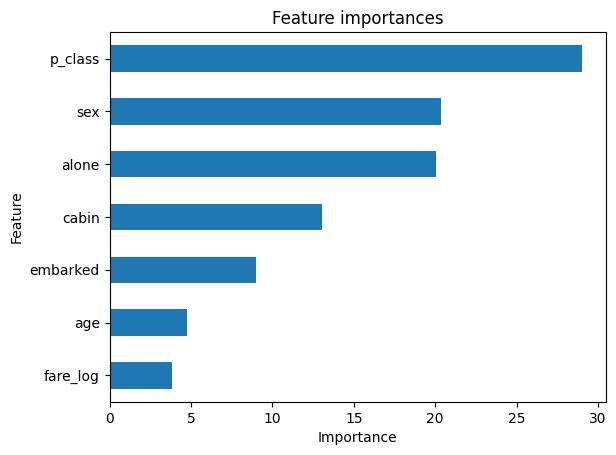

In [47]:
# Create a DF with feature importances and feature names
report = pd.DataFrame(columns=['feature', 'value'])
report['feature'] = estimator.feature_names_in_
report['value'] = estimator.steps[1][1].feature_importances_
report = report.sort_values(by='value', ascending=True).set_index('feature')

report.plot(kind='barh', legend=False)
plt.title('Feature importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

##### Insights
- p_class is the most valuable feature for survival, the second and the third most valuable features are sex and family aboard.

### Results submission

In [48]:
prediction = estimator.predict(test_data)
result = pd.DataFrame(data=test_data['passenger_id'])
result['survived'] = prediction
result.columns = ['PassengerId', 'Survived']
result.to_csv('result.csv', index=False)

## Conclusion
- Finished pre-processing (missing values, duplicates)
- Finished EDA, described descriptions. Completed feature engeneering: added 2 features with higher correlation coefficient than basic features: alone (having family aboard: 1 - yes, 0 - no) and fare_log (fare logarithm to get rid of outliers influence to model quality)
- Trained CatBoostClassifier model with ROC-AUC 0.86 on CV and Accuracy 0.79 on test.